<a href="https://colab.research.google.com/github/ch3rnoalpha/League-of-legends-game-data/blob/main/Project_2_Part_5_(Core)_league_of_legends_game_statistics_john_paredes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Context
League of Legends is a MOBA (multiplayer online battle arena) where 2 teams (blue and red) face off. There are 3 lanes, a jungle, and 5 roles. The goal is to take down the enemy Nexus to win the game.**


[Kaggle Link](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min)

In [ ]:
# Imports needed libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix
from sklearn import set_config
set_config(display='diagram')

In [ ]:
#let me see inital full dataset
from google.colab.data_table import DataTable
DataTable.max_columns = 40

In [ ]:
#sets file to filename and creates a DF for it
filename = '/content/high_diamond_ranked_10min.csv'
df = pd.read_csv(filename)
df.head()

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   

   redTowersDestroyed  redTotalGold  redAvgLevel  redTotalExperience  \
0                   0         16567          6.8               17047   
1                   1         17620          6.8               17438   
2                   0         17285          6.8               17254   
3                   0         16478          7.0               17961   
4                   0         17404          7.0               18313   

   redTotalMinionsKilled  redTotalJungleMinionsKilled  redGoldDiff  \
0                    197                           55         -643   
1                    240                           52         2908   
2                    203                           28         1172   
3                    235                           47         1321   
4                    225                           67         1004   

   redExperienceDiff  redCSPerMin  redGoldPerMin  
0                  8         19.7         1656.7  
1               1173         24.0         1762.0  
2               1033         20.3         1728.5  
3                  7         23.5         1647.8  
4               -230         22.5         1740.4  

[5 rows x 40 columns]

In [ ]:
#drops the last 19 columns of data, since we can just look at the stats for blue team and have the model predict off of that, can always add red data back in.
df = df.drop(df.columns[-19:], axis=1)

In [ ]:
#quick info on the dataframe, and verifies that the red team data was dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

First choice: dataset 1

1) Source of data

  **kaggle**

2) Brief description of data


**League of Legends is a MOBA (multiplayer online battle arena) where 2 teams (blue and red) face off. There are 3 lanes, a jungle, and 5 roles. The goal is to take down the enemy Nexus to win the game.**

3) What is the target?

**If the blue team will win based off all factors**

4) Is this a classification or regression problem?

**Classification**

5) How many features?

**40, but only blue teams data is needed**

6) How many rows of data.

**9879**

7) What, if any, challenges do your foresee in cleaning, exploring, or modeling with this dataset?

**Making sure i dont cause data leakage as i have had issues with that in the past.**


In [ ]:
#############################################################################################################################################################################
# Start of exploration

In [ ]:
# sets all columns to lower case
df.columns = df.columns.str.lower()

In [ ]:
#drops duplicates
df.drop_duplicates(keep=False, inplace=True)

In [ ]:
#displays duplicated data
df.duplicated().sum()

0

In [ ]:
#shows totals of NA data
df.isna().sum()

gameid                          0
bluewins                        0
bluewardsplaced                 0
bluewardsdestroyed              0
bluefirstblood                  0
bluekills                       0
bluedeaths                      0
blueassists                     0
blueelitemonsters               0
bluedragons                     0
blueheralds                     0
bluetowersdestroyed             0
bluetotalgold                   0
blueavglevel                    0
bluetotalexperience             0
bluetotalminionskilled          0
bluetotaljungleminionskilled    0
bluegolddiff                    0
blueexperiencediff              0
bluecspermin                    0
bluegoldpermin                  0
dtype: int64

In [ ]:
#gets info on all columns to look for outliers, none found.
df.describe()

gameid     bluewins  bluewardsplaced  bluewardsdestroyed  \
count  9.879000e+03  9879.000000      9879.000000         9879.000000   
mean   4.500084e+09     0.499038        22.288288            2.824881   
std    2.757328e+07     0.500024        18.019177            2.174998   
min    4.295358e+09     0.000000         5.000000            0.000000   
25%    4.483301e+09     0.000000        14.000000            1.000000   
50%    4.510920e+09     0.000000        16.000000            3.000000   
75%    4.521733e+09     1.000000        20.000000            4.000000   
max    4.527991e+09     1.000000       250.000000           27.000000   

       bluefirstblood    bluekills   bluedeaths  blueassists  \
count     9879.000000  9879.000000  9879.000000  9879.000000   
mean         0.504808     6.183925     6.137666     6.645106   
std          0.500002     3.011028     2.933818     4.064520   
min          0.000000     0.000000     0.000000     0.000000   
25%          0.000000     4.000000     4.000000     4.000000   
50%          1.000000     6.000000     6.000000     6.000000   
75%          1.000000     8.000000     8.000000     9.000000   
max          1.000000    22.000000    22.000000    29.000000   

       blueelitemonsters  bluedragons  ...  bluetowersdestroyed  \
count        9879.000000  9879.000000  ...          9879.000000   
mean            0.549954     0.361980  ...             0.051422   
std             0.625527     0.480597  ...             0.244369   
min             0.000000     0.000000  ...             0.000000   
25%             0.000000     0.000000  ...             0.000000   
50%             0.000000     0.000000  ...             0.000000   
75%             1.000000     1.000000  ...             0.000000   
max             2.000000     1.000000  ...             4.000000   

       bluetotalgold  blueavglevel  bluetotalexperience  \
count    9879.000000   9879.000000          9879.000000   
mean    16503.455512      6.916004         17928.110133   
std      1535.446636      0.305146          1200.523764   
min     10730.000000      4.600000         10098.000000   
25%     15415.500000      6.800000         17168.000000   
50%     16398.000000      7.000000         17951.000000   
75%     17459.000000      7.200000         18724.000000   
max     23701.000000      8.000000         22224.000000   

       bluetotalminionskilled  bluetotaljungleminionskilled  bluegolddiff  \
count             9879.000000                   9879.000000   9879.000000   
mean               216.699565                     50.509667     14.414111   
std                 21.858437                      9.898282   2453.349179   
min                 90.000000                      0.000000 -10830.000000   
25%                202.000000                     44.000000  -1585.500000   
50%                218.000000                     50.000000     14.000000   
75%                232.000000                     56.000000   1596.000000   
max                283.000000                     92.000000  11467.000000   

       blueexperiencediff  bluecspermin  bluegoldpermin  
count         9879.000000   9879.000000     9879.000000  
mean           -33.620306     21.669956     1650.345551  
std           1920.370438      2.185844      153.544664  
min          -9333.000000      9.000000     1073.000000  
25%          -1290.500000     20.200000     1541.550000  
50%            -28.000000     21.800000     1639.800000  
75%           1212.000000     23.200000     1745.900000  
max           8348.000000     28.300000     2370.100000  

[8 rows x 21 columns]

In [ ]:
######################################################################################################################################################################
# start of Visualizations

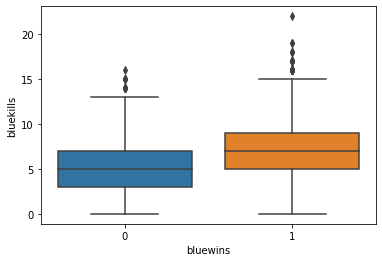

In [ ]:
#very simple boxplot to show relation
sns.boxplot(x='bluewins', y='bluekills', data=df)

Very simple box plot shows us that as expected, if blue team has more kills by the 10 minute marker, they are more likley to win them ath as awhole, the reverse is true for blue team deaths as shown below

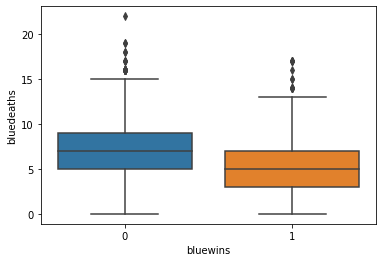

In [ ]:
#very simple boxplot to show relation
sns.boxplot(x='bluewins', y='bluedeaths', data=df)

In [ ]:
#creates a correlation matrix
corr = df.corr()

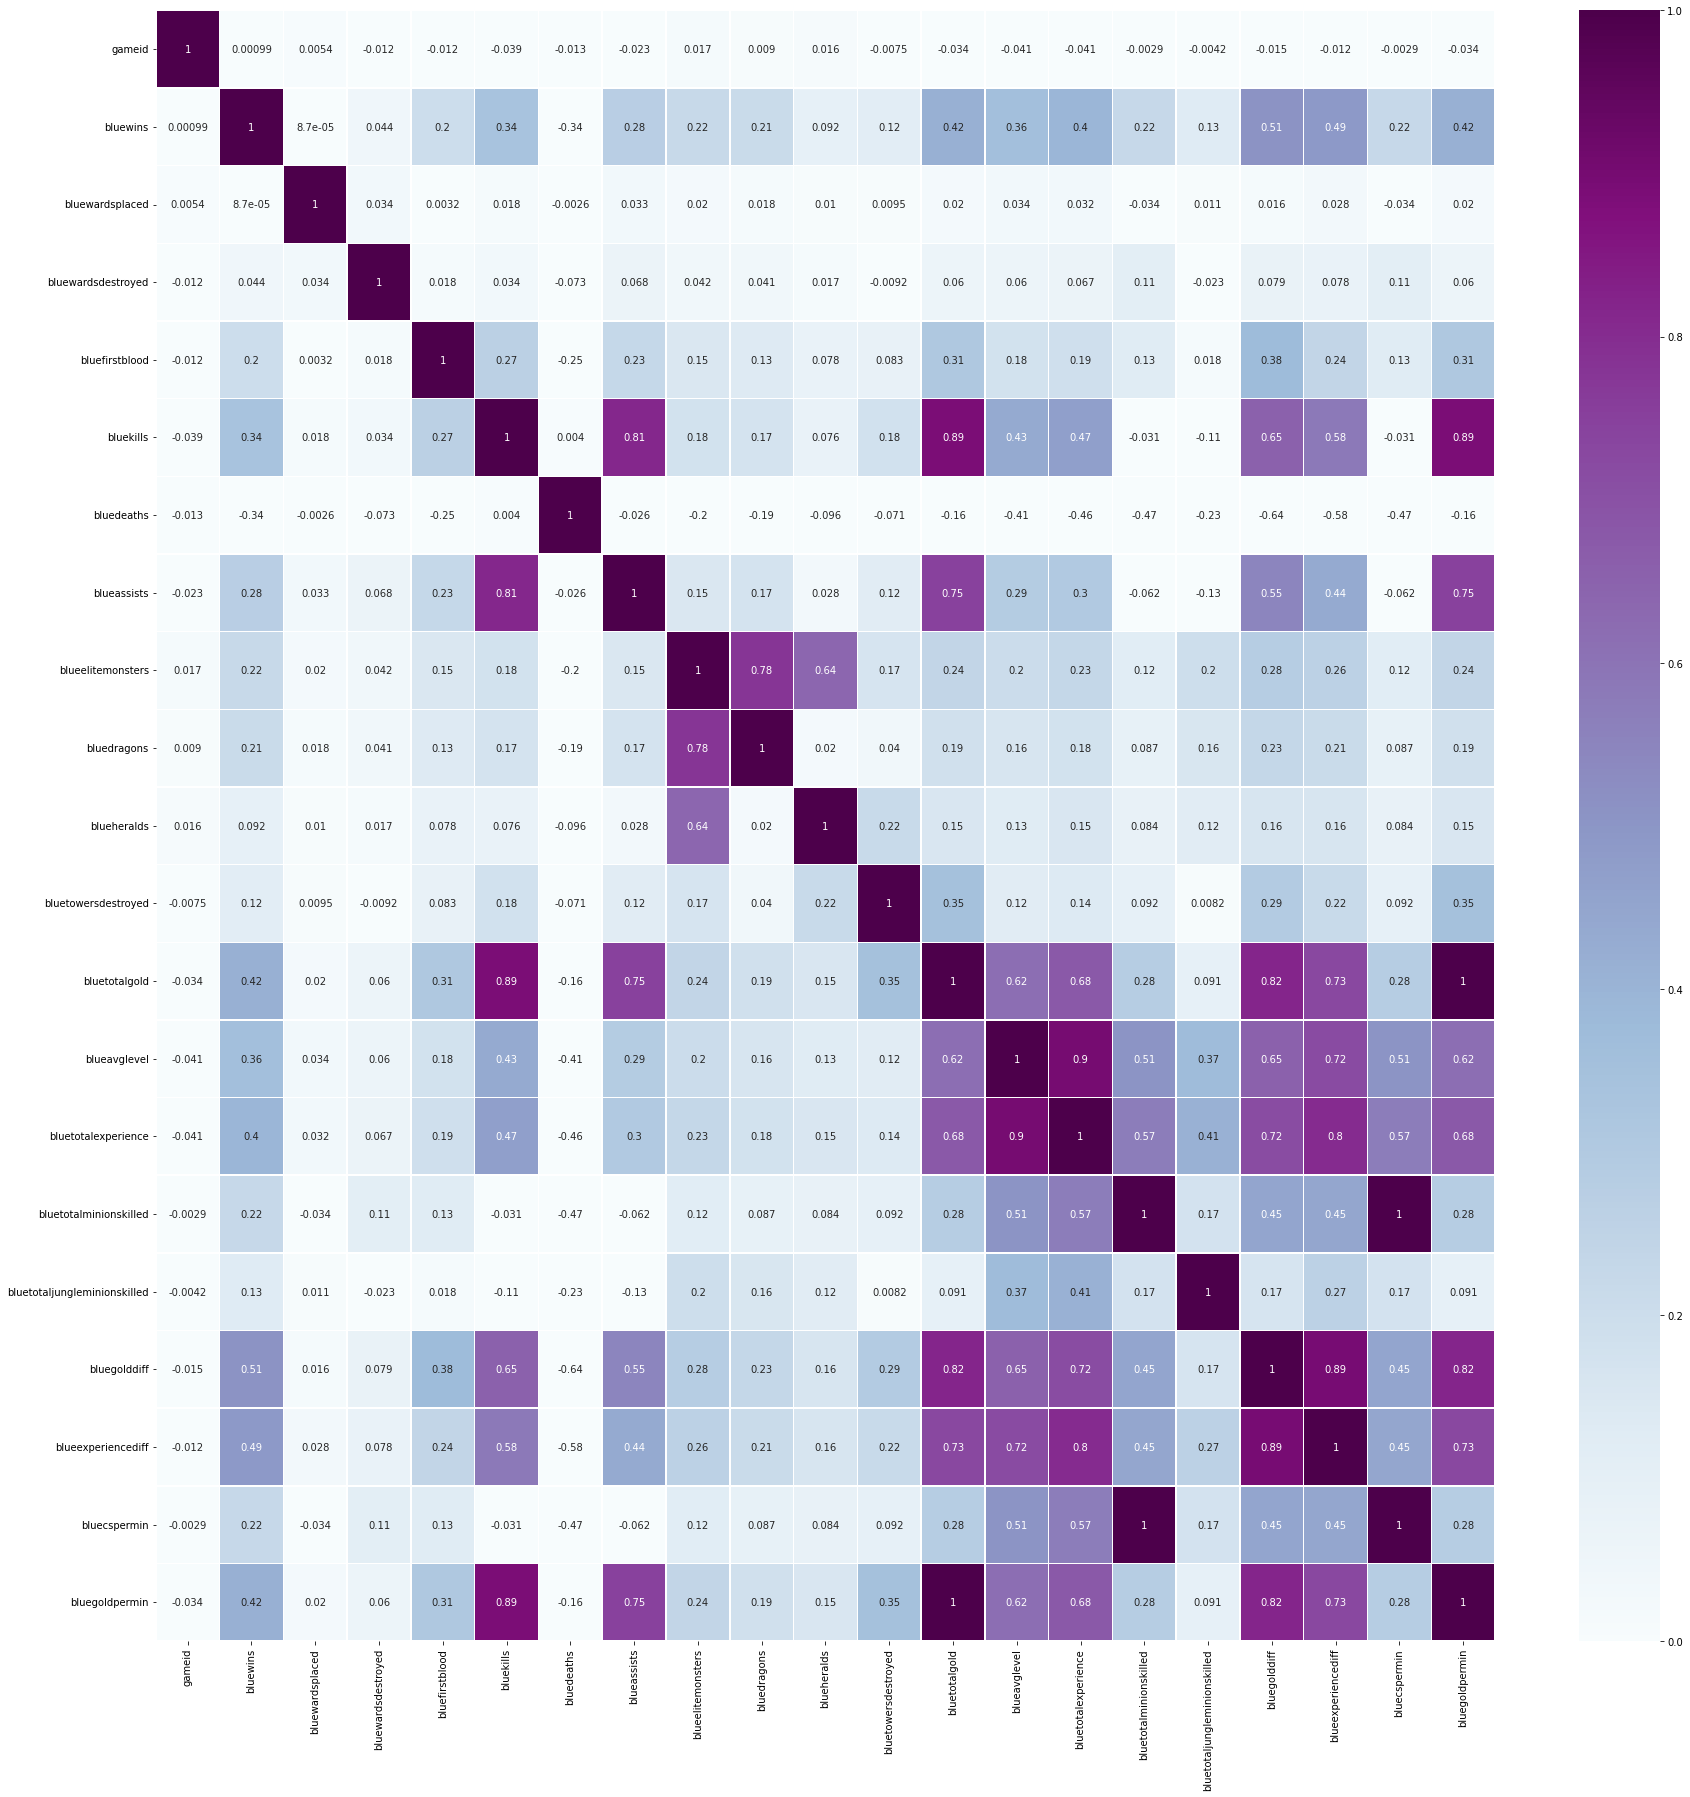

In [ ]:
#creteas a heat map to show potential relations to look into
#sets map size to be readable
plt.figure(figsize = (30,30))


sns.heatmap(corr, cmap = 'BuPu', annot = True, 
            vmin=0, vmax=1, linewidths=.5)

There is a strong correlation between blue team winning, and these features:

1. Gold per minute
2. Experience difference
3. gold difference
4. blue team kills
5. average level


# **Part 3**

Instead of stakeholders, this would be geared towards critea for recruiting players for a pro team.



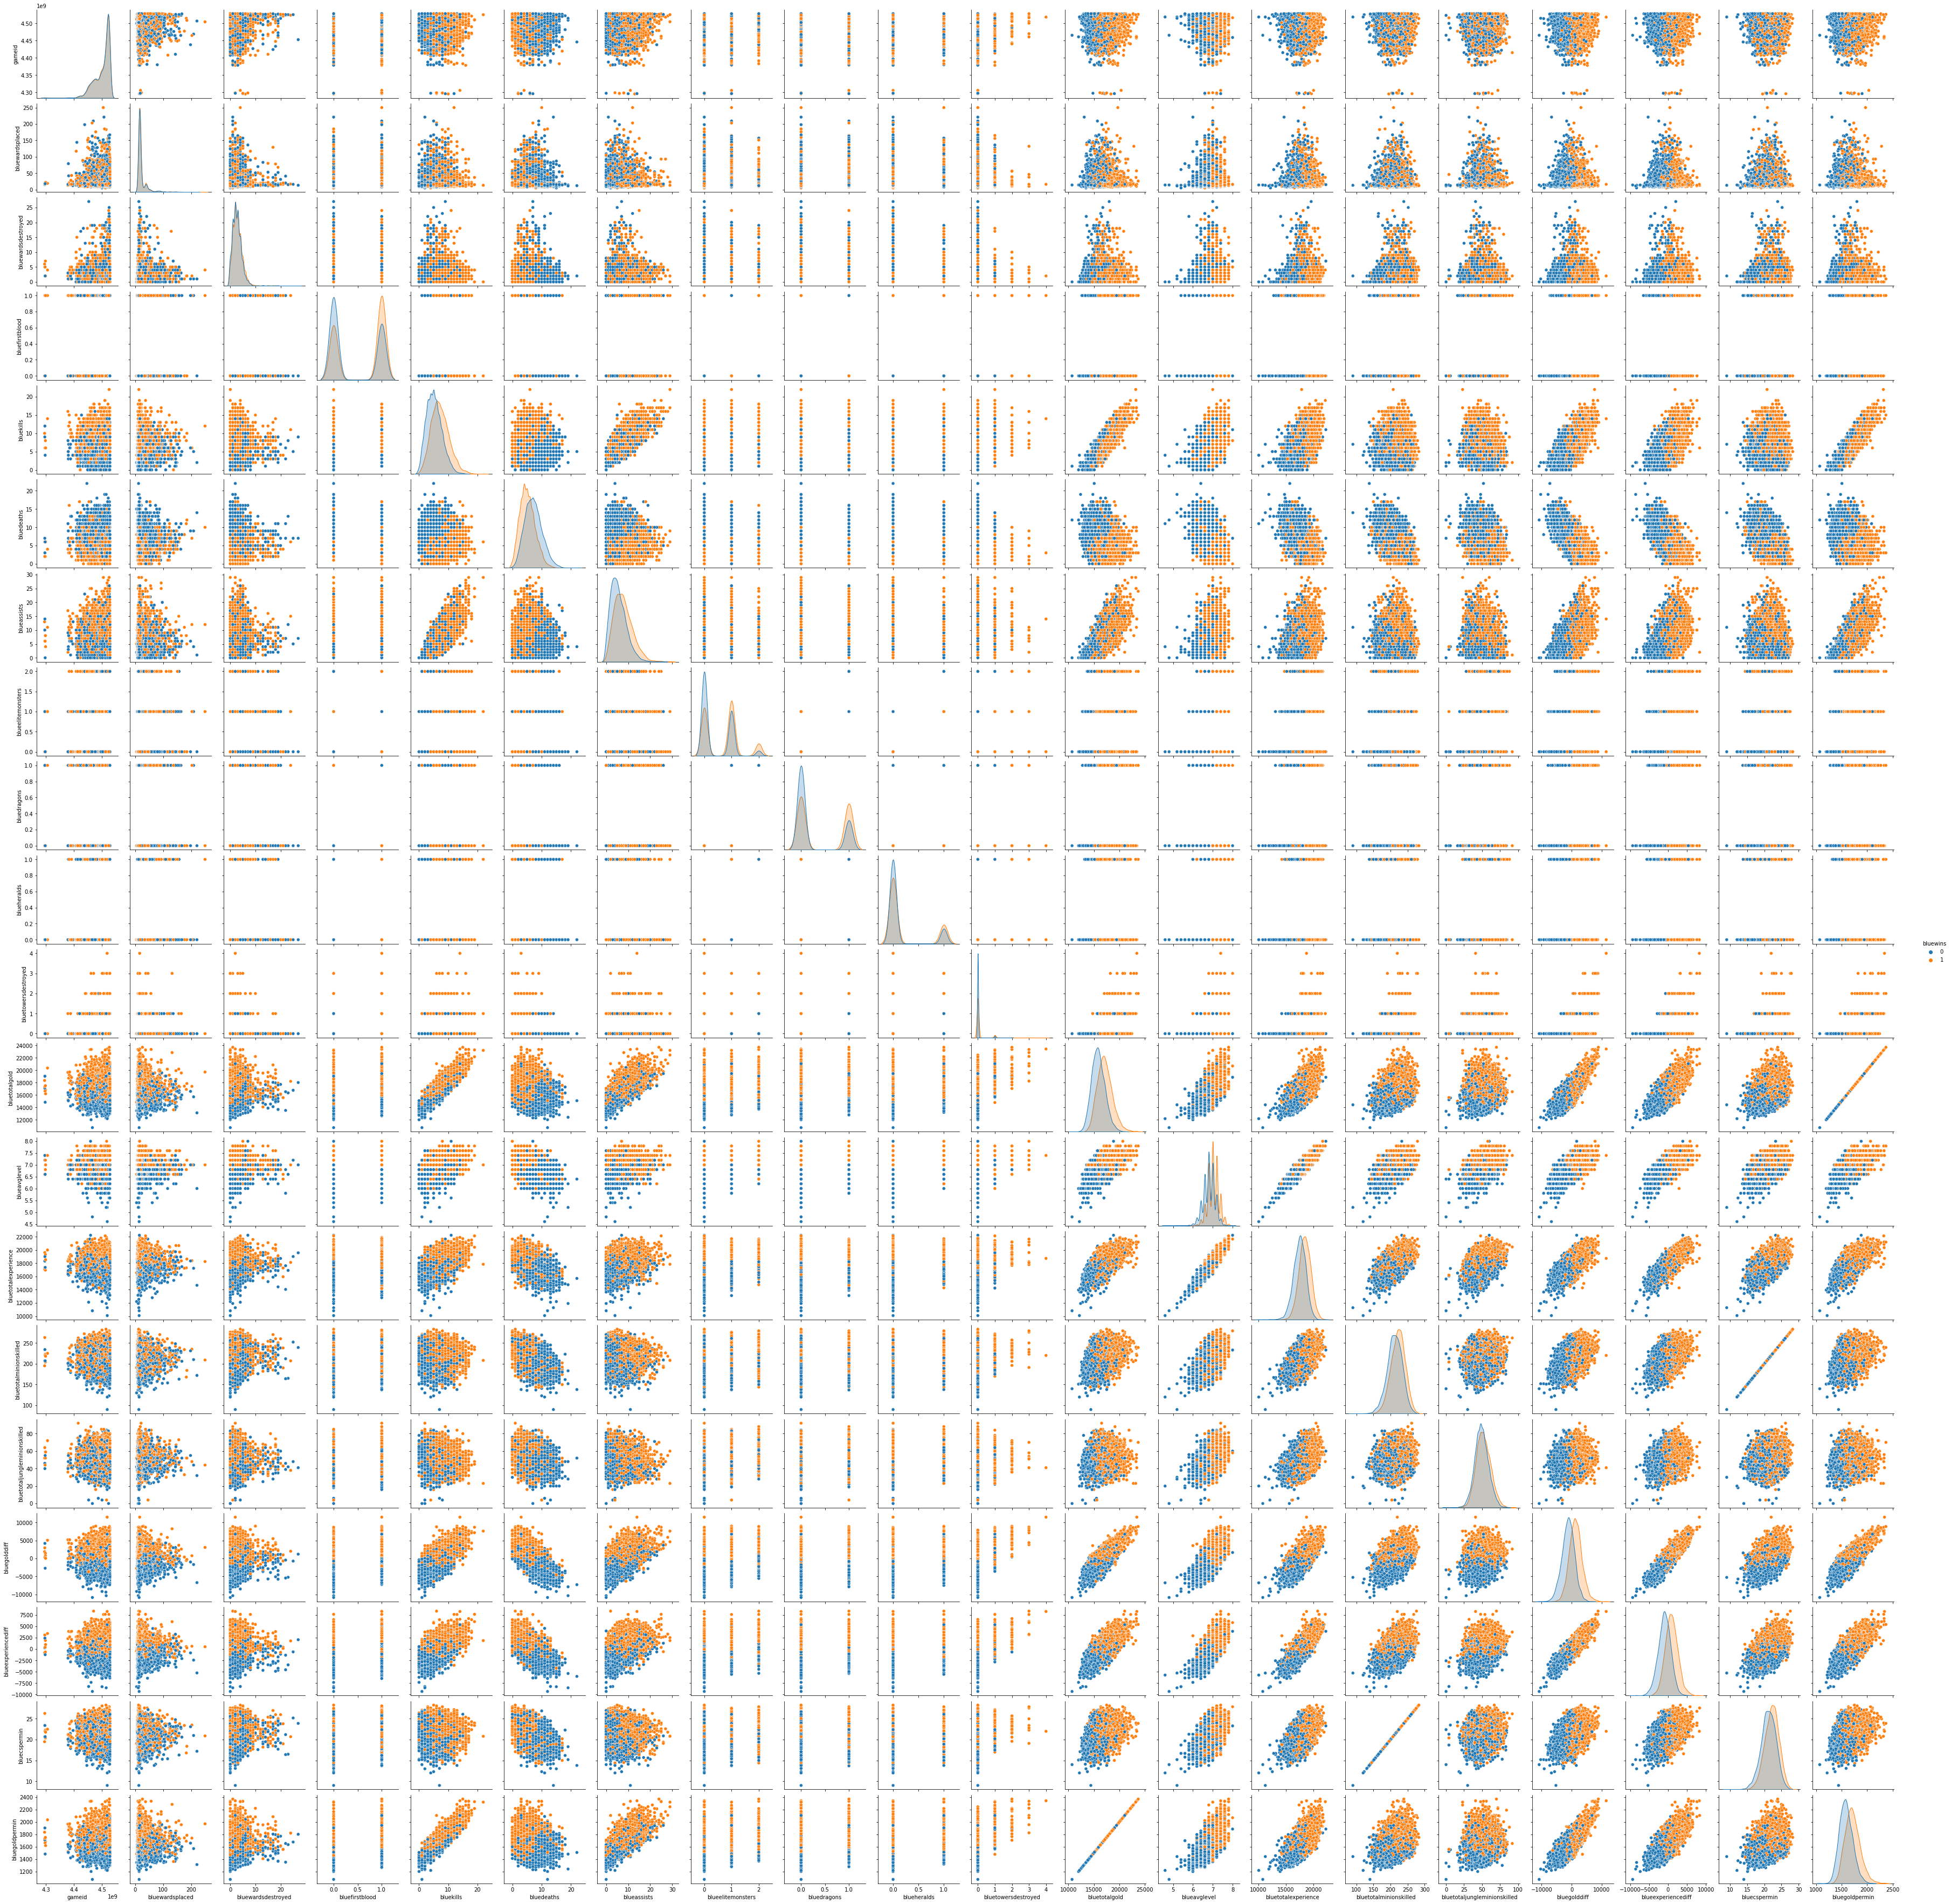

In [ ]:
sns.pairplot(df, hue="bluewins")

Using this pair plot, we can see that in almost very case, when blue team went on to win the match, their values for all data points trend higher than the matches where they lost, which is obvious, and expected. But there are cases where they sacrafice certain things to secure another, which indicates that there are very complex decisions that are made based off the situation of each match.

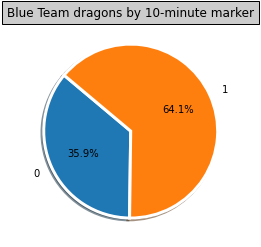

In [ ]:
#graphs a piechart for first dragon
blue_dragons = df.groupby('bluewins')['bluedragons'].sum()

dragon_count='0', '1'

plt.pie(blue_dragons,labels=dragon_count, labeldistance=1.15, 
        wedgeprops = { 'linewidth' : 3, 
                      'edgecolor' : 'white' },
        autopct='%1.1f%%',shadow=True, startangle=140);

plt.title('Blue Team dragons by 10-minute marker', bbox={'facecolor':'0.8', 'pad':5});

This simple chart shows that by 10-minutes, 64.1% of blue teams that get the first dragon kill of the game go onto win the match, which would give heavy inpportance on looking for objectice oriented players for a team.

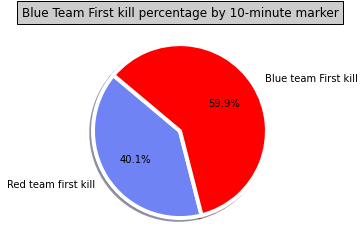

In [ ]:
#graphs a piechart for first kills
blue_dragons = df.groupby('bluewins')['bluefirstblood'].sum()


colors = ['#6F83F4','#FF0000',]
first_kill='Red team first kill', 'Blue team First kill'

plt.pie(blue_dragons,
        labels=first_kill, 
        labeldistance=1.15,
        colors=colors,
        wedgeprops = { 'linewidth' : 4, 
                      'edgecolor' : 'white' },
        autopct='%1.1f%%',
        shadow=True, 
        startangle=140);

plt.title('Blue Team First kill percentage by 10-minute marker', bbox={'facecolor':'0.8', 'pad':5});

Using another pie chart to be able to easily compare to dragons by the 10 minute marker, we can see that 60% of games won, blue team had the first kill of the match, even though this is a smaller percentage than first dragon, getting the first kill can happen before the first dragon even spawns in at the 5 minute mark, making getting the first kill a top priority for a team, and then looking to secure dragon soon after

In [ ]:
######################################################################################################################################################################
# start of pre processing

In [ ]:
#evaluation function for model metrics, took from class work
def evaluate_classification(y_true, y_predicted, average=None):
  accuracy = accuracy_score(y_true, y_predicted)
  recall = recall_score(y_true, y_predicted, average=average)
  precision = precision_score(y_true, y_predicted, average=average)
  f1 = f1_score(y_true, y_predicted, average=average)

  print(f'Accuracy: {accuracy} \nRecall: {recall} \nPrecision: {precision} \nF1 Score: {f1}')

In [ ]:
#sets up train/test split
X = df.drop(columns='bluewins')
y = df['bluewins']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Instantiate Standard Scaler because scaling is required for logistic regression
scaler = StandardScaler()
dec_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

num_selector = make_column_selector(dtype_include = 'number')

#creates a tuple passing the columns through the scaler
num_tuple = (scaler, num_selector)

#turns it back into a column to  be passed into model pieplines
col_trans = make_column_transformer(num_tuple, remainder = 'passthrough')

# Put scaler and model in a pipeline
knn_pipe = make_pipeline(col_trans, knn)

# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y 
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5387c3790>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
#model makes predictions and sets it to an outcome variable
knn_pipe_train_preds = knn_pipe.predict(X_train)
knn_pipe_test_preds = knn_pipe.predict(X_test)

In [ ]:
#creates a report on model accuracy/scores
print('Classification Report for Training Set')
knn_train_report = classification_report(y_train, knn_pipe_train_preds)
print(knn_train_report)

print('Classification Report for Testing Set')

knn_test_report = classification_report(y_test, knn_pipe_test_preds)
print(knn_test_report)

Classification Report for Training Set
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      3713
           1       0.79      0.78      0.78      3696

    accuracy                           0.78      7409
   macro avg       0.78      0.78      0.78      7409
weighted avg       0.78      0.78      0.78      7409

Classification Report for Testing Set
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1236
           1       0.67      0.67      0.67      1234

    accuracy                           0.67      2470
   macro avg       0.67      0.67      0.67      2470
weighted avg       0.67      0.67      0.67      2470



In [ ]:
#sets up random forrest pipeline
rf_pipe = make_pipeline(col_trans, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5387c3790>)])),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
#gets random forrest training predictions
rf_train_preds = rf_pipe.predict(X_train)
rf_test_preds = rf_pipe.predict(X_test)

In [ ]:
#creates a report on model accuracy/scores
print('Classification Report for Training Set')
rf_train_report = classification_report(y_train, rf_train_preds)
print(rf_train_report)

print('Classification Report for Testing Set')

rf_test_report = classification_report(y_test, rf_test_preds)
print(rf_test_report)

Classification Report for Training Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3713
           1       1.00      1.00      1.00      3696

    accuracy                           1.00      7409
   macro avg       1.00      1.00      1.00      7409
weighted avg       1.00      1.00      1.00      7409

Classification Report for Testing Set
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1236
           1       0.71      0.69      0.70      1234

    accuracy                           0.71      2470
   macro avg       0.71      0.71      0.71      2470
weighted avg       0.71      0.71      0.71      2470



In [ ]:
#list of paramaters and the ranges to be ran through
knn_params = {'kneighborsclassifier__leaf_size': range(1,10),
          'kneighborsclassifier__n_neighbors': range(1,10)}

In [ ]:
#creates a gridsearch for the KNN model
knn_grid = GridSearchCV(knn_pipe, knn_params, cv= 2)

In [ ]:
#shows runtime and fits grid to data
%%time

knn_grid.fit(X_train, y_train)

CPU times: user 56.2 s, sys: 17.8 s, total: 1min 14s
Wall time: 55.1 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5387c3790>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__leaf_size': range(1, 10),
                         'kneighborsclassifier__n_neighbors': range(1, 10)})

In [ ]:
#prints best hyper peramaters within given range
print(knn_grid.best_params_)

{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 9}


In [ ]:
#gives a new pipeline the best hyperparameters
best_knn = knn_grid.best_estimator_
best_knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa53900fe50>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=9))])

In [ ]:
#fits new model to data
best_knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa53900fe50>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=9))])

In [ ]:
#new prediction scores
best_knn_train_preds = best_knn.predict(X_train)
best_knn_test_preds = best_knn.predict(X_test)

In [ ]:
#new model scores with hypertuned parameteres
print('Classification Report for Training Set')
knn2_train_report = classification_report(y_train, best_knn_train_preds)
print(knn2_train_report)

print('Classification Report for Testing Set')

knn2_test_report = classification_report(y_test, best_knn_test_preds)
print(knn2_test_report)

Classification Report for Training Set
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      3713
           1       0.76      0.74      0.75      3696

    accuracy                           0.75      7409
   macro avg       0.75      0.75      0.75      7409
weighted avg       0.75      0.75      0.75      7409

Classification Report for Testing Set
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1236
           1       0.69      0.67      0.68      1234

    accuracy                           0.68      2470
   macro avg       0.68      0.68      0.68      2470
weighted avg       0.68      0.68      0.68      2470



In [ ]:
#Use confusion_matrix() to print confusion matrices for both models
best_knn_cm = confusion_matrix(y_test.values, best_knn_test_preds)
 
best_knn_cm

array([[863, 373],
       [408, 826]])

After searching for better hyper parameters, we were able to increase our accuracy by 1%, which then makes the tuned KNN model the best option out of the ones i have tried. The rf model was also way over fit on the training data after dropping all red team data.

In [ ]:
#Recreate the confusion matrix above, but with the values normalized along the 'true' axis.
confusion_matrix(y_test, best_knn_test_preds, normalize = 'true')

array([[0.69822006, 0.30177994],
       [0.33063209, 0.66936791]])